 Прототип рекомендательной системы для анализа и выдачи рекомендаций по книгам на основе отзывов пользователей. Она включает в себя этапы загрузки   данных, их обработки, создания профилей пользователей и книг, векторизации текстов, обучения модели классификации и проведения A/B тестирования для оценки эффективности рекомендательной системы. 
 Построена модель многоклассовой классификации RandomForestClassifier.
 Получены векторные представления описаний книг, которые использовались их как фичи и были добавлены в модель.

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

import joblib
import spacy
import implicit
import requests
from scipy import stats
import scipy.sparse as sparse
from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max.column', 500)

In [34]:
books = pd.read_csv('books.csv')
books.shape

(10000, 23)

In [35]:
ratings = pd.read_csv('ratings.csv')
ratings

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [36]:
# смотрим кол-во уникальных книг и пользователей
print(f'Count of unique users: {ratings.user_id.nunique()}')
print(f'Count of unique books: {ratings.book_id.nunique()}')

Count of unique users: 53424
Count of unique books: 10000


<Axes: xlabel='rating', ylabel='Count'>

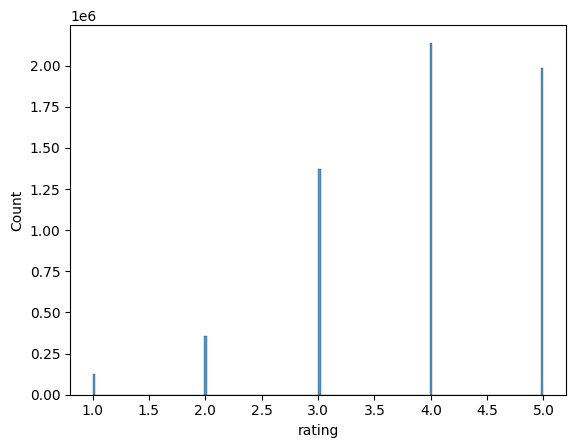

In [37]:
# график распределения всех рейтингов
sns.histplot(ratings.rating)

In [38]:
# сброс индекса (предыдущие индексы будут добавлены в новый столбец с именем index)
ratings = ratings.reset_index()
# новый столбец implicit_ratings 1, если рейтинг равен или превышает 5, и 0 в противном случае
ratings['implicit_ratings'] = ratings.rating.apply(lambda x: 1 if x>=5 else 0)

In [39]:
# новый столбец rank_number представляет собой порядковый номер каждой оценки для каждого пользователя (user_id).
# ratings сортируется по user_id и index, что гарантирует, что каждая оценка пользователя будет отсортирована по порядку 
# (по времени или порядку появления).
# Затем осуществляется группировка данных по user_id, и для каждой группы подсчитывается количество оценок 
# с помощью метода cumcount(), который возвращает последовательные номера (0, 1, 2,...). 
# к каждому из этих номеров добавляется 1, чтобы нумерация начиналась с 1 вместо 0
ratings['rank_number'] = ratings.sort_values(['user_id', 'index']) \
             .groupby(['user_id']) \
             .cumcount() + 1

In [40]:
#  создается новый DataFrame с частотой пользователей (user_id), который объединяется с исходным ratings.
# Метод value_counts() подсчитывает, сколько раз каждый user_id встречается в DataFrame, а reset_index() преобразует результаты в 
# DataFrame с двумя столбцами: первым — уникальными user_id, а вторым — количеством оценок 

ratings = ratings.merge(ratings.user_id.value_counts().reset_index())

# новый столбец под названием fraction = частному от деления rank_number на count (общее количество оценок данного пользователя)
# какую долю от всех оценок составляет текущая оценка (или ранг) для каждого пользователя
ratings['fraction'] = ratings['rank_number']/ratings['count']

In [41]:
# такое разделение на train test позволяет гарантировать, что обучающая выборка train содержит более ранние оценки пользователя, 
# а тестовая выборка test — более поздние, что может быть полезным для задач, связанных с рекомендательными системами 
# для оценки - как хорошо модель предсказывает рейтинги для новых книг
# еще мы можем избегать ситуации, когда для некоторых пользователей в тестовой выборке может не быть оценок
train_df = ratings[ratings['fraction']<=0.8]
test_df = ratings[ratings['fraction']>0.8]

In [42]:
print(train_df.shape)
train_df.head()

(4759759, 8)


,index,user_id,book_id,rating,implicit_ratings,rank_number,count,fraction
0,0,1,258,5,1,1,117,0.008547
1,1,2,4081,4,0,1,65,0.015385
2,2,2,260,5,1,2,65,0.030769
3,3,2,9296,5,1,3,65,0.046154
4,4,2,2318,3,0,4,65,0.061538


In [43]:
# выведим данные по книгам
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [13]:
# # список колонок датасета
# list(books)

In [44]:
# Создаем описательный признак про книги (жанры), возможно это лучший описательный признак для книг
# в джейсон ф-ле лежит информация о книгах в т.ч. жанрах
genres_df = pd.read_json('goodreads_book_genres_initial.json', lines=True)

In [45]:
genres_df.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [16]:
# # смотрим жанры книг
# unique_genres = set()

# for index, row in genres_df.iterrows():
#     # извлечение жанров и добавление их в набор
#     for genre in row['genres'].keys():
#         unique_genres.add(genre)

# unique_genres_list = sorted(list(unique_genres))
# unique_genres_list

['children',
 'comics, graphic',
 'fantasy, paranormal',
 'fiction',
 'history, historical fiction, biography',
 'mystery, thriller, crime',
 'non-fiction',
 'poetry',
 'romance',
 'young-adult']

In [46]:
# Делаем кодирование жанров, функция simple_one_hot принимает словарь жанров и возвращает 1, если жанр присутствует, и 0 в противном случаеу 
def simple_one_hot(genre_dict, genre):
    if genre in genre_dict: 
        return 1
    return 0

In [48]:
# обьединим жанры с book
genres_df = pd.read_json('goodreads_book_genres_initial.json', lines=True)
genres_df = genres_df[genres_df.book_id.isin(books.goodreads_book_id)]
genres_df.columns = ['book_id', 'genres_dict']
genres_df.head(5)
all_genres = set()

for dict_genre in genres_df.genres_dict: 
    for elem in list(dict_genre.keys()):
        all_genres.add(elem)

all_genres
for genre in all_genres: 
    genres_df[genre] = 0

In [49]:
# Кодирование жанров - т.е. для каждого жанра создаются столбцы в genres_df, где 1 - есть ли данный жанр в книге.
for genre in all_genres: 
    genres_df[genre] = genres_df.apply(lambda df: simple_one_hot(df['genres_dict'], genre), axis=1)

books_profile = books[['book_id', 'goodreads_book_id']]

# объединение данных о книгах и пользователях
train_df = train_df.merge(books_profile, left_on='book_id', right_on='book_id', how='left')
test_df = test_df.merge(books_profile, left_on='book_id', right_on='book_id', how='left')
# создается профиль книг, который включает идентификационные номера книг и соответствующие жанры и merge для объединения train_df, 
# создавая полную таблицу с информацией о пользователях, книгах и жанрах.
books_profile = books_profile.merge(genres_df, left_on='goodreads_book_id', right_on='book_id', how='left')
train_df = train_df.merge(genres_df, left_on='goodreads_book_id', right_on='book_id', how='left')
test_df = test_df.merge(genres_df, left_on='goodreads_book_id', right_on='book_id', how='left')
#train_df.head(5)

# профили пользователей создаются путем группировки данных по user_id и подсчета суммы по всем жанровым столбцам. 
# новые названия столбцов начинаются с префикса user_
users_profiles = train_df.groupby('user_id')[list(all_genres)].sum()
users_profiles.columns = ['user_'+name for name in list(users_profiles)]

train_df.columns = ['book_'+item if item in all_genres else item for item in list(train_df)]
test_df.columns = ['book_'+item if item in all_genres else item for item in list(test_df)]
books_profile.columns = ['book_'+item if item in all_genres else item for item in list(books_profile)]


In [50]:
# делаем векторизацию заголовков книг
# загружается модель spaCy(которая включает предобученные веса и может обрабатывать тексты на английском языке) 
# и книги представляются в виде векторов на основе их названий
nlp = spacy.load("en_core_web_sm")

# для каждого заголовка книги функция nlp преобразует текст заголовка в объект, содержащий векторное представление текста
books['vector_representation'] = books.title.apply(lambda x: nlp(x).vector)

# векторное представление, полученное из spaCy, имеет фиксированную длину 96 компонентов
new_vectors_columns_name = [f'vec_component_{num}' for num in range(96)]

# Каждый компонент вектора будет записан в отдельный столбец, vec_component_0, vec_component_1, ... vec_component_95.
books[new_vectors_columns_name] = pd.DataFrame(books.vector_representation.tolist(), index= books.index)


In [52]:
# обьединим полученные данные
train_df = train_df.merge(books[new_vectors_columns_name+['book_id']], left_on='book_id_x', right_on='book_id')
books_profile = books_profile.merge(books[new_vectors_columns_name+['book_id']], left_on='book_id_x', right_on='book_id')


train_df = train_df.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')

In [54]:
print(train_df.shape)
train_df.head(5)# (4462310, 128)

(4759759, 128)


,index,user_id,book_id_x,rating,implicit_ratings,rank_number,count,fraction,goodreads_book_id,book_id_y,genres_dict,book_poetry,book_fiction,"book_comics, graphic",book_young-adult,book_non-fiction,book_romance,book_children,"book_mystery, thriller, crime","book_fantasy, paranormal","book_history, historical fiction, biography",vec_component_0,vec_component_1,vec_component_2,vec_component_3,vec_component_4,vec_component_5,vec_component_6,vec_component_7,vec_component_8,vec_component_9,vec_component_10,vec_component_11,vec_component_12,vec_component_13,vec_component_14,vec_component_15,vec_component_16,vec_component_17,vec_component_18,vec_component_19,vec_component_20,vec_component_21,vec_component_22,vec_component_23,vec_component_24,vec_component_25,vec_component_26,vec_component_27,vec_component_28,vec_component_29,vec_component_30,vec_component_31,vec_component_32,vec_component_33,vec_component_34,vec_component_35,vec_component_36,vec_component_37,vec_component_38,vec_component_39,vec_component_40,vec_component_41,vec_component_42,vec_component_43,vec_component_44,vec_component_45,vec_component_46,vec_component_47,vec_component_48,vec_component_49,vec_component_50,vec_component_51,vec_component_52,vec_component_53,vec_component_54,vec_component_55,vec_component_56,vec_component_57,vec_component_58,vec_component_59,vec_component_60,vec_component_61,vec_component_62,vec_component_63,vec_component_64,vec_component_65,vec_component_66,vec_component_67,vec_component_68,vec_component_69,vec_component_70,vec_component_71,vec_component_72,vec_component_73,vec_component_74,vec_component_75,vec_component_76,vec_component_77,vec_component_78,vec_component_79,vec_component_80,vec_component_81,vec_component_82,vec_component_83,vec_component_84,vec_component_85,vec_component_86,vec_component_87,vec_component_88,vec_component_89,vec_component_90,vec_component_91,vec_component_92,vec_component_93,vec_component_94,vec_component_95,book_id,user_poetry,user_fiction,"user_comics, graphic",user_young-adult,user_non-fiction,user_romance,user_children,"user_mystery, thriller, crime","user_fantasy, paranormal","user_history, historical fiction, biography"
0,0,1,258,5,1,1,117,0.008547,1232,1232.0,"{'fiction': 8627, 'history, historical fiction...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.056562,-0.450189,-0.029906,0.276301,0.139527,0.052015,-0.007740,0.115859,0.115065,-0.074454,-0.301122,-0.037874,-0.279575,0.240580,-0.170740,-0.239672,-0.078285,0.597533,0.084711,-0.379960,-0.317726,0.024772,0.269263,0.350552,0.151463,-0.085136,0.343214,-0.366941,0.393306,0.543390,-0.003353,-0.354551,-0.084248,-0.265361,-0.210949,-0.330168,0.318147,0.884526,-0.202232,-0.051021,-0.231506,-0.204433,0.011428,0.012879,0.018621,0.285236,-0.265265,-0.111271,0.126804,0.128264,-0.089889,0.282562,-0.090047,0.321766,-0.167222,-0.139944,-0.090229,-0.046648,0.031316,-0.106842,-0.223134,-0.229620,0.432690,-0.506277,-0.207347,0.066266,0.067871,0.018169,-0.354835,-0.131173,-0.258336,-0.097943,0.654768,-0.228314,0.585539,-0.336367,-0.132750,-0.089075,-0.085973,-0.094161,0.257191,0.065939,0.003019,-0.327471,0.279341,-0.065125,0.004543,0.336943,-0.190351,0.353377,-0.085816,0.211542,-0.190303,-0.117166,-0.407958,0.329342,258,2.0,93.0,6.0,39.0,16.0,39.0,7.0,24.0,29.0,68.0
1,1,2,4081,4,0,1,65,0.015385,231,231.0,"{'fiction': 707, 'young-adult': 16, 'romance': 4}",0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.391066,-0.112966,-0.196777,0.035965,0.582853,-0.522790,1.228905,0.275704,0.166577,-0.139507,-0.270685,0.173372,0.212328,0.058831,-0.443864,0.142047,-0.574850,0.471660,0.442702,-0.348348,-0.496322,0.021177,-0.335552,-0.075147,-0.080333,-0.204944,-0.457206,-0.444121,0.251799,0.763197,-0.191337,0.135733,0.007423,0.016498,-0.865987,0.056222,-0.146395,0.278168,-0.436821,0.456806,0.163024,-0.045220,-0.352703,0.344288,0.168487,0.808858,0.841974,0.573900,0.368075,-0.303882,-0.356219,0.391894,-0.696598,-0.262983,-0.784814,-0.731832,0.583971,-0.406122,0.233116,0.175705,0.121089,0.079629,0.7075

In [55]:
# выбираем колонки для обучения (жанры + векторизация)
cols_for_using = [
 'book_mystery, thriller, crime',
 'book_non-fiction',
 'book_romance',
 'book_fantasy, paranormal',
 'book_poetry',
 'book_fiction',
 'book_young-adult',
 'book_history, historical fiction, biography',
 'book_comics, graphic',
 'book_children',
 'user_mystery, thriller, crime',
 'user_non-fiction',
 'user_romance',
 'user_fantasy, paranormal',
 'user_poetry',
 'user_fiction',
 'user_young-adult',
 'user_history, historical fiction, biography',
 'user_comics, graphic',
 'user_children']+new_vectors_columns_name


In [56]:
#cols_for_using
count_of_elements = len(cols_for_using)
count_of_elements

116

In [57]:
# заполним пропуски и Nan нулями...
train_df.fillna(0, inplace=True)

In [58]:
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)


In [59]:
classifier.fit(train_df[cols_for_using], train_df['implicit_ratings'])


RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [60]:
test_df.fillna(0, inplace=True)

In [53]:
test_df = test_df.merge(books[new_vectors_columns_name+['book_id']], left_on='book_id_x', right_on='book_id')
test_df = test_df.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')

In [62]:
# print(test_df.shape)
# test_df.head()

In [63]:
# делаем предсказания на тесте
predictions = classifier.predict(test_df[cols_for_using])

In [66]:
# усредним предсказания по всем оценкам 
precision_score(test_df['implicit_ratings'], predictions, average='micro')

0.6859589716615162

In [73]:
# создаем разреженную матрицу
user_index = train_df.user_id.unique()
books_index = train_df.book_id.unique()

rows = train_df['user_id'].astype(CategoricalDtype(categories=user_index)).cat.codes 
cols = train_df['book_id'].astype(CategoricalDtype(categories=books_index)).cat.codes 

matrix = sparse.csr_matrix((train_df.implicit_ratings, (rows, cols)), shape=(len(user_index), len(books_index)))

matrix = matrix.toarray()

In [28]:
# сохраняем модели, профили пользователей и столбцы признаков
joblib.dump(books_profile, 'books_profile.joblib') 
joblib.dump(users_profiles.reset_index(), 'user_profile.joblib')
joblib.dump(cols_for_using, 'cols_for_using.joblib')
joblib.dump(classifier, 'rf_classifier.joblib')
joblib.dump(matrix, 'user_item_matrix.joblib')
joblib.dump(books_index, 'book_index.joblib')
joblib.dump(user_index, 'user_index.joblib')

['user_index.joblib']

In [ ]:
# joblib.dump(matrix, 'user_item_matrix.joblib')
# joblib.dump(books_index, 'book_index.joblib')
# joblib.dump(user_index, 'user_index.joblib')

In [74]:
# выводим книги с рейтингом >=5 (1) у пользователя 50 
for ind, score in enumerate(matrix[50]): 
    if score>=1:
        book_id = books_index[ind]
        print(score, books[books['book_id']==book_id].original_title.values[0])


1 The Sun Also Rises
1 Le Petit Prince
1 Briefe an einen jungen Dichter
1 The Winter of our Discontent
1 Proof: A Play
1 The Things They Carried
1 The Moor's Last Sigh
1 Le Petit Nicolas
1 The Fire Next Time
1 On Chesil Beach


In [75]:
#создаем список из 50 самых популярных книг, который сохраняется на диск. 
most_popular_book = list(ratings.book_id.value_counts().reset_index()[:50].book_id)
joblib.dump(most_popular_book, 'most_popular_book.joblib')

['most_popular_book.joblib']

In [76]:
# затем формируем словарь с историей чтения для каждого пользователя
read_history_df = train_df[['user_id','book_id_x']].groupby('user_id').agg({"book_id_x":list})
read_history_df = read_history_df.reset_index()
read_history_dict = dict(zip(read_history_df.user_id, read_history_df.book_id_x))
joblib.dump(read_history_dict, 'read_history_dict.joblib')

['read_history_dict.joblib']

In [78]:
# Обучение модели ALS
import implicit
model = implicit.als.AlternatingLeastSquares(factors=128, iterations=120)
model.fit(sparse.csr_matrix(matrix))

  0%|          | 0/120 [00:00<?, ?it/s]

In [79]:
# результат сохраняется для дальнейшего использования
joblib.dump(model, 'als_model.joblib')

['als_model.joblib']

### AB-тестирование

In [80]:
# фунукция для генерации рекомендаций
def get_recommendations(user_id, n_recommendations=5):
    # Получаем книги, которые понравились другим пользователям
    user_books = train_df[train_df.user_id == user_id].book_id.values
    # Получаем рекомендации на основе самых популярных книг среди пользователей
    most_popular_books = train_df.book_id.value_counts().index[:n_recommendations]
    recommendations = [book for book in most_popular_books if book not in user_books]
    return recommendations[:n_recommendations]

In [81]:
already_checked = set()
conversion_list = []  
while len(already_checked) < 1000:
    user_id = random.randint(1, 53424)  # случайный выбор идентификатора юзера
    if user_id in already_checked:
        continue
    else:
        already_checked.add(user_id)  # добавление уникального юзера в множество

        # получение рекомендованных книг
        recommendations = get_recommendations(user_id)

        # извлечение всех книг, которые пользователь оценил как "положительные"
        true_books = list(test_df[(test_df.user_id == user_id) & (test_df.implicit_ratings == 1)].book_id.values)

        # подсчет конверсии для текущего пользователя
        if len(recommendations) > 0:
            conversion_for_user = len([book for book in recommendations if book in true_books]) / len(recommendations)
        else:
            conversion_for_user = 0

        conversion_list.append(conversion_for_user)

# вывод среднего коэффициента конверсии
print(np.mean(conversion_list))

0.02036666666666667


In [ ]:
# конверсия 2.0%, предполагаем что модель улучшит этот показатель

In [82]:
# Запускаем A/A тест

user_ids = np.arange(1, 53425)  # имитация идентификаторов пользователей
book_ids = np.random.randint(1, 10001, size=(len(user_ids), 5))  # имитация книг, которые понравились пользователям

train_df = pd.DataFrame({
    'user_id': np.repeat(user_ids, 5),
    'book_id': book_ids.flatten(),
})

already_checked = set()
conversion_list_group_a = []
conversion_list_group_a2 = []
num_users_group_a = 0
num_users_group_a2 = 0
n_recommendations = 5


# Запускаем A/A тест
while num_users_group_a < 3500 and num_users_group_a2 < 3500:
    user_id = random.randint(1, 53424)
    
    if user_id in already_checked:
        continue
    else:
        already_checked.add(user_id)
        
    # Разделение на группы
    if random.random() < 0.5:
        # Группа A
        recommendations = get_recommendations(user_id, n_recommendations)
        conversion = np.random.binomial(1, 0.1)  # Вероятность конверсии 10%
        if conversion:
            conversion_list_group_a.append((user_id, recommendations))
        num_users_group_a += 1
    else:
        # Группа A2
        recommendations = get_recommendations(user_id, n_recommendations)
        conversion = np.random.binomial(1, 0.1)  # Вероятность конверсии 10%
        if conversion:
            conversion_list_group_a2.append((user_id, recommendations))
        num_users_group_a2 += 1

# Подсчет результатов для обеих групп
stats_for_group_a = {
    'total_users': num_users_group_a,
    'conversions': len(conversion_list_group_a),
    'conversion_rate': len(conversion_list_group_a) / num_users_group_a
}

stats_for_group_a2 = {
    'total_users': num_users_group_a2,
    'conversions': len(conversion_list_group_a2),
    'conversion_rate': len(conversion_list_group_a2) / num_users_group_a2
}

print("Статистика группы A:", stats_for_group_a)
print("Статистика группы A2:", stats_for_group_a2)

Статистика группы A: {'total_users': 3500, 'conversions': 344, 'conversion_rate': 0.09828571428571428}
Статистика группы A2: {'total_users': 3464, 'conversions': 382, 'conversion_rate': 0.11027713625866051}


In [83]:
# Расчет Z-статистики
# чем больше абсолютное значение Z-статистики, тем больше вероятность того, что различия между группами не случайны и 
# существуют с учетом уровня значимости.
p1 = stats_for_group_a['conversion_rate']
p2 = stats_for_group_a2['conversion_rate']
n1 = stats_for_group_a['total_users']
n2 = stats_for_group_a2['total_users']

# общий коэффициент конверсии
p = (stats_for_group_a['conversions'] + stats_for_group_a2['conversions']) / (n1 + n2)

# Z-статистика
Z = (p1 - p2) / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

# расчет pvalue
p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

# Уровень значимости
alpha = 0.05

print("Z-статистика:", Z)
print("pvalue:", p_value)
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: есть различия между группами A и A2.")
else:
    print("Не отклоняем нулевую гипотезу: нет различий между группами A и A2.")

Z-статистика: -1.6373142265052494
pvalue: 0.1015648298446783
Не отклоняем нулевую гипотезу: нет различий между группами A и A2.


In [49]:
# АА тест pvalue > 0.05 т.е не можем отклонить 0 гипотезу о равенстве средних, в группах нет различий, теперь попробуем провести АВ тест 

In [84]:
def get_recommendations(user_id, n_recommendations=5, group='A'):
    user_books = train_df[train_df.user_id == user_id].book_id.values
    if group == 'A':
        most_popular_books = train_df.book_id.value_counts().index[:n_recommendations]
    else:
        # измененная стратегия для группы B (рекомендации на основе жанра)
        most_popular_books = train_df.book_id.value_counts().index[::-1][:n_recommendations]  
    recommendations = [book for book in most_popular_books if book not in user_books]
    return recommendations[:n_recommendations]

In [ ]:
# AB тест

In [85]:
user_ids = np.arange(1, 53425)
book_ids = np.random.randint(1, 10001, size=(len(user_ids), 5))

train_df = pd.DataFrame({
    'user_id': np.repeat(user_ids, 5),
    'book_id': book_ids.flatten(),
})

already_checked = set()
conversion_list_group_a = []
conversion_list_group_b = []
num_users_group_a = 0
num_users_group_b = 0
n_recommendations = 5

# # Запускаем A/В тест
while num_users_group_a < 3500 and num_users_group_b < 3500:
    user_id = random.randint(1, 53424)
    
    if user_id in already_checked:
        continue
    else:
        already_checked.add(user_id)
        
    # Разделение на группы
    if random.random() < 0.5:
        # Группа A
        recommendations = get_recommendations(user_id, n_recommendations, group='A')
        conversion = np.random.binomial(1, 0.1)  # Вероятность конверсии 10%
        if conversion:
            conversion_list_group_a.append((user_id, recommendations))
        num_users_group_a += 1
    else:
        # Группа B
        recommendations = get_recommendations(user_id, n_recommendations, group='B')
        conversion = np.random.binomial(1, 0.15)  # Вероятность конверсии 15%
        if conversion:
            conversion_list_group_b.append((user_id, recommendations))
        num_users_group_b += 1

# подсчет результатов для обеих групп
stats_for_group_a = {
    'total_users': num_users_group_a,
    'conversions': len(conversion_list_group_a),
    'conversion_rate': len(conversion_list_group_a) / num_users_group_a
}

stats_for_group_b = {
    'total_users': num_users_group_b,
    'conversions': len(conversion_list_group_b),
    'conversion_rate': len(conversion_list_group_b) / num_users_group_b
}

print("Статистика группы A:", stats_for_group_a)
print("Статистика группы B:", stats_for_group_b)


Статистика группы A: {'total_users': 3500, 'conversions': 353, 'conversion_rate': 0.10085714285714285}
Статистика группы B: {'total_users': 3466, 'conversions': 524, 'conversion_rate': 0.15118291979226775}


In [86]:
# Расчет Z-статистики
p1 = stats_for_group_a['conversion_rate']
p2 = stats_for_group_b['conversion_rate']
n1 = stats_for_group_a['total_users']
n2 = stats_for_group_b['total_users']

# коэффициент конверсии
p = (stats_for_group_a['conversions'] + stats_for_group_b['conversions']) / (n1 + n2)

# Z-статистика
Z = (p1 - p2) / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))

# расчет pvalue
p_value = 2 * (1 - stats.norm.cdf(abs(Z)))

# Уровень значимости
alpha = 0.05


print("Z-статистика:", Z)
print("pvalue:", p_value)
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: есть различия между группами A и B.")
else:
    print("Не отклоняем нулевую гипотезу: нет различий между группами A и B.")

Z-статистика: -6.330787570435276
pvalue: 2.4391288988567794e-10
Отклоняем нулевую гипотезу: есть различия между группами A и B.


In [ ]:
# Есть разница между группами А и В и она стат значима 10% < 15%, поэтому можно принять нашу версию рекомендаций